# SPIRE FTS data access and data analysis in python 3

## Introduction

The Herschel Science Archive has a I/O interface called HAIO. How to use it is explained in some details in this url http://archives.esac.esa.int/hsa/aio/doc/howto.html

In order to access Herschel data, one can construct an HAIO HTTP request and submit it to the archive.

In the following example, we download SPIRE FTS level-2 data as a tar file, extract the relevant fits file and read it. Then we reorganise the spectral data in a dictionary.

In [1]:
#
# import some necessary packages
#
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import tarfile
import requests
import tempfile
import os, shutil

In [2]:

def getSpireFtsLevel2(obsid, what='spss', archive='hsa'):
    """
    PURPOSE:
        Using the HTTP access to HAIO, retrieve all level-2 products in tar.gz file
        and extract only the requested fits file at then ind it puts the spectral
        structure in a dictionary
    INPUTS:
        obsid - the OBSID of the observation
        what - can be 'spss' for point source calibrated spectra or 'sds' for extended source 
        calibrated data. Note that only non-apodized spectra are searched for. You can change this 
        behaviour in the function below, by replacing '_spg_' with '_spgApod_'.
        archive - cab ne 'hsa' or 'hsaint' (for the integration archive).
    OUTPUTS:
        A nested dictionary with the following structure:
            spec[det]['wave'], spec[det]['flux'], spec[det]['fluxErr'], where det is the name of the 
            detector.
        And the FITS header of the primary extension of the fits file.
    EXAMPLE:
        spss = getSpireFtsLevel2(1342259588)
        print (spss.keys())
        print (spss["SSWD4"].keys())
    TODO:
        * Decide what to extract from the tar file when the observation is in H+LR mode.
    HISTORY:
        Created 16 Mar 2016 (IV), version 1.0
    """
    # the name of the saved tar file.
    tarFile = "%i_level2.tar"%obsid
    archiveUrl = "http://archives.esac.esa.int/%s/aio/jsp/product.jsp"%archive
    haioRequest = "%s?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=Level2"%(archiveUrl,obsid)
    print ("Downloading level-2 data from the Herschel Science Archive. May take a while... be patient")
    #
    # submit the HAIO request to the server
    #
    r = requests.get(haioRequest)
    #
    # save the result in a .tar file
    #
    with open(tarFile, "wb") as tmp:
        tmp.write(r.content)
    #
    # now read the downloaded tar file
    #
    xx = None
    with tarfile.open(tarFile,'r') as tar:
        for member in tar.getnames():
            tmpdir = tempfile.mkdtemp()
            if ((what in member) and ('_spg_' in member)):
                f=tar.extract(member,tmpdir)
                xx = fits.open(os.path.join(tmpdir,member))
                break
            # clean up the temprary folder with the extracted file
            shutil.rmtree(tmpdir)
    if (xx == None):
        print ("*** OBSID %i is not an FTS sparse mode. Return."%obsid)
        return None, None
    spec = {}
    # get the primary header
    header = xx[0].header
    for k in xx:
        extname = k.name
        if ('S' in extname):
            spec[k.name] = {}
            spec[k.name]['wave'] = k.data["wave"]
            spec[k.name]['flux'] = k.data["flux"]
            spec[k.name]['fluxErr'] = k.data["error"]
    return spec, header

Now, let's try it with one observation.

In [3]:
spss, hh = getSpireFtsLevel2(1342259588)
print (spss.keys())
print (spss["SSWD4"].keys())
hh
spss2, hh2 = getSpireFtsLevel2(1342195774)


C:\Users\Ivan\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


dict_keys(['SLWD2', 'SSWC2', 'SLWD3', 'SSWC4', 'SLWB2', 'SSWB2', 'SSWF2', 'SSWF3', 'SLWC4', 'SSWC3', 'SLWC3', 'SSWD2', 'SSWE2', 'SSWE4', 'SSWD4', 'SSWE5', 'SSWB3', 'SSWB4', 'SSWC5', 'SSWD6', 'SSWD3', 'SSWE3', 'SLWC2', 'SLWB3'])
dict_keys(['wave', 'flux', 'fluxErr'])
*** OBSID 1342195774 is not an FTS sparse mode. Return.


Let's try to plot all spectra, the central detectors with one colour and the off-axis ones in another.

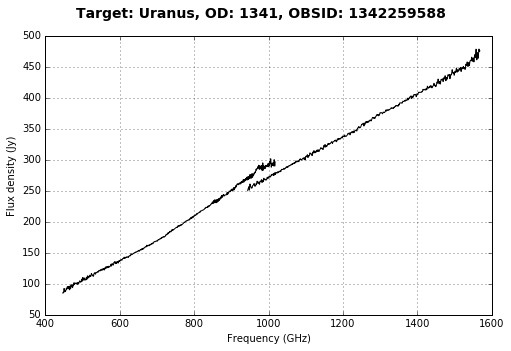

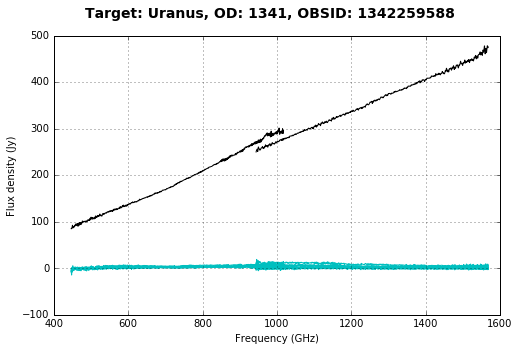

In [4]:
def plotSpireSparseSpec(specIn, fitsHeader=None, onlyCentral=True):
    """
    """
    central = ['SSWD4','SLWC3']
    fig = plt.figure(figsize=(8,5))
    for det in central:
        plt.plot(specIn[det]['wave'],specIn[det]['flux'],'k-')
    if (not onlyCentral): 
        for det in specIn.keys():
            if (not det in central):
                plt.plot(specIn[det]['wave'],specIn[det]['flux'],'c-')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Flux density (Jy)')
    plt.grid(True)
    if (fitsHeader):
        titleText = 'Target: %s, OD: %i, OBSID: %i'%(fitsHeader['OBJECT'],fitsHeader['ODNUMBER'],fitsHeader['OBS_ID'])
        fig.suptitle(titleText, fontsize=14, fontweight='bold')
        #plt.title(titleText)
#
plotSpireSparseSpec(spss, fitsHeader=hh)
#
# add the off axis detectors to the plot
plotSpireSparseSpec(spss, fitsHeader=hh, onlyCentral=False)

## What's next?

Use the provided defs and implement: 
 * A background subtraction function.
 * Pointing offset corrector.
 * Semi-extended corrector.
 * FTS footprint plot.

Short-term implementations:
 * Provide similar dictionary for the mapping observations: preCubes and cubes.
 
Long-term ideas:
 * Create special class for FTS sparse spectra, even better, think about storing the spectral data as HDF5 object.
 * Special class for FTS pre-cubes and spectral cubes.
 * Read access to the non-averaged spectral products, i.e. for each detector and each spectral scan.
 
_Ivan Valtchanov_, Herschel Science Centre, March 2016